In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

In [2]:
# saved files testing
from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

In [3]:
def apply_best_on_packets(packets, max_fitness, flow_id):

    index = max_fitness[1][2]
    #print(index)
    if index == 0:
        return packets
    
    params = max_fitness[1][1][index-1] # best technique
    #print(f'saved:{params}')
    
    if index == 1:
        #print('packet_size_nor')
        #print(f'size: {prepare_size_stats(packets, flow_id)}')
        
        return adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
        
                
    elif index == 2:
        #print('packet_size_uni')
        #print(f'size: {prepare_size_stats(packets, flow_id)}')
        return adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
    elif index == 3:
        #print('packet_time_norm')
        #print(f'time: {prepare_timing_stats(packets, flow_id)}')
        return apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
    elif index == 4:
        #print('packet_time_uni')
        #print(f'time: {prepare_timing_stats(packets, flow_id)}')
        return apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])
        
    return packets

In [45]:
import pygad
import copy

class FlowOptimizer:
    def __init__(self, packets, model_name, flow_id, max_fitness):
        self.packets = packets
        self.model_name = model_name
        self.flow_id = flow_id
        self.ga_instance = None
        self.max_fitness = max_fitness
        
    def apply_best_solution(self):
        best_solution, best_solution_fitness, _ = self.ga_instance.best_solution()
        best_operations = self.decode_operations(best_solution)
        # Stosujemy najlepsze operacje do pakietów
        self.best_modified_packets = self.apply_operations_to_packets(best_operations, self.packets, self.flow_id)
        # Możesz zwrócić więcej informacji o najlepszym rozwiązaniu, jeśli potrzebujesz
        return self.best_modified_packets, best_solution_fitness

    def on_generation(self, ga_instance):
        #current_population = ga_instance.population
        #print(f"Flow ID: {self.flow_id}, Pokolenie: {ga_instance.generations_completed}")
        #print("Aktualna populacja:")
        #for solution in current_population:
        #    print(solution)
        # Tworzymy wiadomość zawierającą interesujące nas informacje
        #message = f"Najlepszy wynik: {ga_instance.best_solution()[1]}\n"
        #print(message)  # Wyświetlamy informacje na konsoli
        
        # Zapisujemy te same informacje do pliku
        #with open(f"progress_for_flow_{self.flow_id}.txt", "a") as file:
        #    file.write(message)
        pass
            
    def on_fitness(self, ga_instance):
        ga_instance.plot_fitness()

    def fitness_function(self, ga_instance, solution, solution_idx):
        
        fitnesses = []
        target_fitnesses = []
        
        operations = self.decode_operations(solution)
        
        modified_packets = self.packets # always check nop
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[0], op_type = 'size_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        #print(sizing_stats)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[1], op_type = 'size_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[2], op_type = 'time_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[3], op_type = 'time_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        #ZMIANY PONIZEJ POWODUJA ZE OPERUJE NA TARGET I NA TYM MUSZE SIE SKUPIC
        #max_fitness_value = max(fitnesses) orig
        #max_fitness_index = fitnesses.index(max_fitness_value) orig
        max_fitness_value = max(target_fitnesses) #TODO: TESTING FOR FITNESS TARGET
        max_fitness_index = target_fitnesses.index(max_fitness_value) #TODO: TESTING FOR FITNESS TARGET
        #print(max_fitness_index)

        max_fitness_target = target_fitnesses[max_fitness_index]

        
        # Zapisz maksymalną wartość fitness i indeks, jeśli jest większa niż obecnie zapisana maksymalna wartość
        #print(self.max_fitness)
        if max_fitness_value > self.max_fitness[0][0]:
            #print(f'CONDITION max: {max_fitness_value}, prev: {self.max_fitness[0]}')
            self.max_fitness = [[max_fitness_value, max_fitness_target], self.decode_operations(solution), max_fitness_index]
            #print(f'self:{self.max_fitness[0]}')
        
        #print(max_fitness_value)
        #print(f'solution:{solution}')
        #print(f'finresses: {fitnesses}, solution:{self.decode_operations(solution)}')
        
        return max_fitness_value

    def optimize_for_flow(self):
        
        #with open(f"progress_for_flow_{self.flow_id}.txt", "w") as file:
        #    file.write("")  # Tylko czyszczenie zawartości pliku
            
        ga_instance = pygad.GA(num_generations=2,
                               num_parents_mating=1,
                               fitness_func=self.fitness_function,
                               sol_per_pop=3,                          
                               mutation_probability=0.7,
                               suppress_warnings= True,
                               on_generation=self.on_generation,
                               num_genes=6,  # Przykład, dostosuj do ilości operacji
                               gene_space = [{'low': 1.1, 'high': 5.0},  # size normal
                                             {'low': 0.25, 'high': 5.0}, # packet size uniform
                                             {'low': 1.1, 'high': 3.0}, # time normal
                                             {'low': 0.4, 'high': 2.4}, # time uniform
                                            [0,1,2],  # direction
                                            [0,1,2]]) # focus point 

        
        ga_instance.run()
        return ga_instance, self.max_fitness

    def decode_operations(self, genotype):
        operations = []
        

        focus_point_map = {0: "start", 1: "middle", 2: "end"}
        focus_point = None
        focus_point_index = genotype[5] 
        focus_point = focus_point_map.get(focus_point_index, None)  

        size_norm = {
            'scaling_factor': genotype[0],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        size_uni = {
            'scaling_factor': genotype[1],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        time_norm = {
            'scaling_factor': genotype[2],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        
        time_uni = {
            'scaling_factor': genotype[3],
            'direction': genotype[4],
            'focus_point': focus_point
        }  
            
            
        
        operations = [size_norm, size_uni, time_norm, time_uni]
        return operations 
        


    def apply_operations_to_packets(self, operation, op_type):

        #packets = copy.deepcopy(self.packets) # deep copy for testing
        #print(f'size: {prepare_size_stats(self.packets, self.flow_id)}')
        #print(f'time: {prepare_timing_stats(self.packets, self.flow_id)}')


        scaling_factor = operation['scaling_factor']
        direction = operation.get('direction')
        focus_point = operation.get('focus_point')
        

        if op_type == 'size_norm':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'normal', scaling_factor, focus_point)
            
            
        elif op_type == 'size_uni':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'uniform', scaling_factor, focus_point)
            
        elif op_type == 'time_norm':
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'normal', focus_point, scaling_factor)
            
        elif op_type == 'time_uni':
            #print(f'przed: {prepare_timing_stats(self.packets, self.flow_id)}')
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'uniform', focus_point, scaling_factor)
            #print(f'po: {prepare_timing_stats(packets, self.flow_id)}')
            
        #print(packets)
        return packets
    

            
        

    #print(optimizer.best_solution())
    


In [5]:
import os
import pickle

def save_object_pickle(obj, filepath):
    """
    Saves an object to a specified filepath using pickle.
    
    Parameters:
    - obj: The object to save.
    - filepath: The path to the file where the object should be saved.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    with open(filepath, 'wb') as pickle_file:  # Note 'wb' for writing in binary mode
        pickle.dump(obj, pickle_file)

def load_object_pickle(filepath):
    """
    Loads an object from a specified filepath using pickle.
    
    Parameters:
    - filepath: The path to the file from which to load the object.
    
    Returns:
    - The loaded object.
    """
    with open(filepath, 'rb') as pickle_file:  # Note 'rb' for reading in binary mode
        obj = pickle.load(pickle_file)
    return obj


In [54]:
captures = [
    "botnet-capture-20110811-neris",
    "botnet-capture-20110812-rbot",
    "botnet-capture-20110815-fast-flux-2",
    "botnet-capture-20110815-fast-flux",
    "botnet-capture-20110815-rbot-dos",
    "botnet-capture-20110816-donbot",
    "botnet-capture-20110816-qvod",
    "botnet-capture-20110816-sogou",
    "botnet-capture-20110817-bot",
    "botnet-capture-20110818-bot-2",
    "botnet-capture-20110819-bot"
]


In [ ]:
import copy
import os
import pickle

# Załóżmy, że wszystkie funkcje takie jak create_truncated_packets_from_pcap, assign_flow_ids_to_packets, itp., są już zdefiniowane
# Definicja klasy FlowOptimizer i inne potrzebne komponenty

#TODO: zrobic test czy sie dobrze sklada
updated_truncated_packets = None


def process_flow_id(flow_id, packets, model):
    print(f"Starting work on flow_id: {flow_id}")
    truncated_packets = copy.deepcopy(packets)  # Robimy głęboką kopię na poziomie procesu
    inter = []
    max_fitness = [0, [[0, 0], 0, 0], 0]
    previous_max = 0
    
    for i in range(5):
        optimizer = FlowOptimizer(truncated_packets, model, flow_id, max_fitness[1])
        max_fitness = optimizer.optimize_for_flow()
        inter.append(max_fitness[1][0][0])
        
        if max_fitness[1][0][0] > previous_max:
            truncated_packets = apply_best_on_packets(truncated_packets, max_fitness, flow_id)
            previous_max = max_fitness[1][0][0]

    return flow_id, inter, truncated_packets

def main():
    #captures = [
    #    "botnet-capture-20110816-donbot"
    #]

    for capture in captures:
        print(f'Working on capture: {capture}')

        modified_pcap_path = f"../data/interim/{capture}_perturbed.pcapng"
        pcap_file_path = f'../data/raw/filtered/{capture}.pcap'
        save_object_path = f"../data/metadata/ga_rf_fitness_{capture}_perturbed.pkl"
        model_name = f'{capture}'

        truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
        print(f"Total packets loaded: {len(truncated_packets)}")
        truncated_packets = assign_flow_ids_to_packets(truncated_packets)

        flow_ids = set(packet.flow_id for packet in truncated_packets)
        extern = []
        updated_truncated_packets = truncated_packets  # Start with the original packet list

        for fid in flow_ids:
            flow_id, inter, updated_truncated_packets = process_flow_id(fid, updated_truncated_packets, model_name)
            extern.append(inter)
            print(f"Completed processing flow_id {flow_id}, final results: {inter}")

        modify_and_write_packets_one_by_one(pcap_file_path, modified_pcap_path, updated_truncated_packets)
        with open(save_object_path, 'wb') as f:
            pickle.dump(extern, f)

        print(f"Finished and saved: {capture}")

if __name__ == "__main__":
    main()


Working on capture: botnet-capture-20110811-neris
Total packets loaded: 4955
hash groups: 593
Starting work on flow_id: 1
Completed processing flow_id 1, final results: [0.10773343603940744, 0.16199116144234016, 0.1850813541220998, 0.21110234302442532, 0.21218103898903196]
Starting work on flow_id: 2
Completed processing flow_id 2, final results: [0.05291898810064921, 0.0767319547360733, 0.08011078329042665, 0.0836601405322841, 0.0836601405322841]
Starting work on flow_id: 3
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packets to apply perturbation.
Not enough packe

In [51]:
updated_truncated_packets

NameError: name 'updated_truncated_packets' is not defined

In [48]:
# testing 

Testing botnet-capture-20110816-donbot_regressor:
Accuracy: 99.97426%
Predicted distribution: 0    0.999645
dtype: float64
Number of samples: 194
Number of malicious (1) predictions: 0    194
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


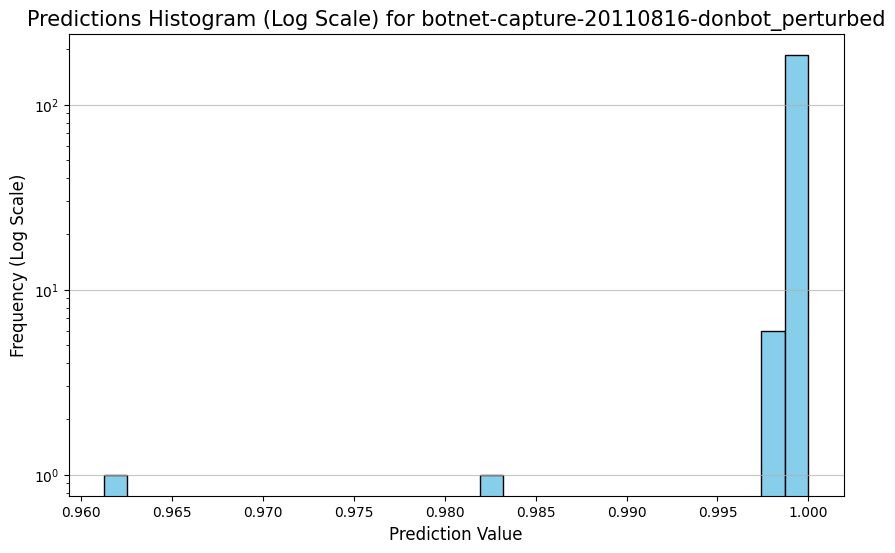

In [49]:
# # after PERTURBATIONS

import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor

import sys, os
sys.path.append(os.path.abspath('../'))
from src.data.cic_preprocess import *

# Directory paths
models_dir = "../models"
#data_dir = "../data/processed"
data_dir = "../data/"

# Loading models
models = {file.split('_model.cbm')[0]: CatBoostRegressor().load_model(os.path.join(models_dir, file))
          for file in os.listdir(models_dir) if file.endswith('.cbm')}

for capture in captures:

    # Testing models
    accuracies = []
    for model_name, model in models.items():
        if capture in model_name and "regressor" in model_name:
            # File name of the test data corresponds to the model name
            test_file_name = f"{capture}_orig_flows.csv"
            test_file_path = os.path.join(data_dir, test_file_name)
            
            # Loading test data
            X_test = preprocess_traffic(test_file_path)
            y_test = np.ones(X_test.shape[0])  # Assuming all samples are malicious, so y_test should be all ones
            
            # Model prediction
            predictions = model.predict(X_test)
            
            # Calculating accuracy
            accuracy = np.mean(predictions)
            accuracies.append(predictions)
            
            predictions = pd.DataFrame(predictions).clip(lower=0, upper =1)
            
            
            # Detailed logging
            print(f"Testing {model_name}:")
            print(f"Accuracy: {accuracy:.5%}")
            print(f"Predicted distribution: {predictions.mean()}")
            print(f"Number of samples: {len(predictions)}")
            print(f"Number of malicious (1) predictions: {np.sum(predictions > 0.5)}")
            print(f"Number of benign (0) predictions: {np.sum(predictions <= 0.5)}\n")

            # Average accuracy
            #mean_accuracy = np.mean(accuracies)
            #print(f"\nAverage accuracy across all test cases: {mean_accuracy:.5%}")
            
           
            import matplotlib.pyplot as plt

            # Assuming your DataFrame is named 'df' and the column with predictions is named 'Predictions'

            plt.figure(figsize=(10, 6))
            plt.hist(predictions, bins=30, color='skyblue', edgecolor='black', log=True)
            plt.title(f'Predictions Histogram (Log Scale) for {capture}_perturbed', fontsize=15)
            plt.xlabel('Prediction Value', fontsize=12)
            plt.ylabel('Frequency (Log Scale)', fontsize=12)
            plt.grid(axis='y', alpha=0.75)

            plt.show()


Testing botnet-capture-20110816-donbot_regressor:
Accuracy: 96.53772%
Predicted distribution: 0    0.964394
dtype: float64
Number of samples: 194
Number of malicious (1) predictions: 0    193
dtype: int64
Number of benign (0) predictions: 0    1
dtype: int64


Average accuracy across all test cases: nan%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


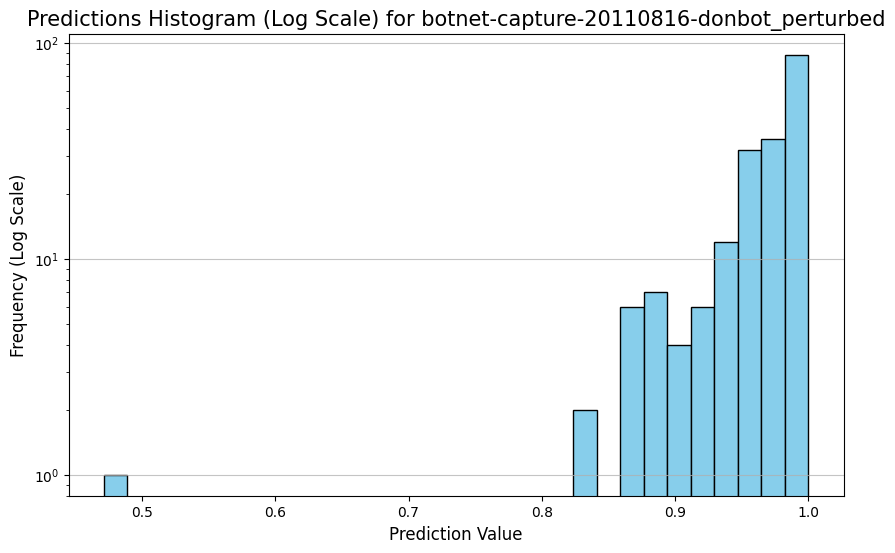

In [50]:
# # after PERTURBATIONS

import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor

import sys, os
sys.path.append(os.path.abspath('../'))
from src.data.cic_preprocess import *

# Directory paths
models_dir = "../models"
#data_dir = "../data/processed" TODO
data_dir = "../data"

# Loading models
models = {file.split('_model.cbm')[0]: CatBoostRegressor().load_model(os.path.join(models_dir, file))
          for file in os.listdir(models_dir) if file.endswith('.cbm')}

for capture in captures:

    # Testing models
    accuracies = []
    for model_name, model in models.items():
        if capture in model_name and "regressor" in model_name:
            # File name of the test data corresponds to the model name
            test_file_name = f"{capture}_perturbed_flows.csv"
            test_file_path = os.path.join(data_dir, test_file_name)
            
            # Loading test data
            X_test = preprocess_traffic(test_file_path)
            y_test = np.ones(X_test.shape[0])  # Assuming all samples are malicious, so y_test should be all ones
            
            # Model prediction
            predictions = model.predict(X_test)
            
            # Calculating accuracy
            accuracy = np.mean(predictions)
            #accuracies.append(predictions)
            
            predictions = pd.DataFrame(predictions).clip(lower=0, upper =1)
            
            
            # Detailed logging
            print(f"Testing {model_name}:")
            print(f"Accuracy: {accuracy:.5%}")
            print(f"Predicted distribution: {predictions.mean()}")
            print(f"Number of samples: {len(predictions)}")
            print(f"Number of malicious (1) predictions: {np.sum(predictions > 0.5)}")
            print(f"Number of benign (0) predictions: {np.sum(predictions <= 0.5)}\n")

            # Average accuracy
            mean_accuracy = np.mean(accuracies)
            print(f"\nAverage accuracy across all test cases: {mean_accuracy:.5%}")
            
           
            import matplotlib.pyplot as plt

            # Assuming your DataFrame is named 'df' and the column with predictions is named 'Predictions'

            plt.figure(figsize=(10, 6))
            plt.hist(predictions, bins=30, color='skyblue', edgecolor='black', log=True)
            plt.title(f'Predictions Histogram (Log Scale) for {capture}_perturbed', fontsize=15)
            plt.xlabel('Prediction Value', fontsize=12)
            plt.ylabel('Frequency (Log Scale)', fontsize=12)
            plt.grid(axis='y', alpha=0.75)

            plt.show()
